# Learning `pyspark`

This notebook is focused on learning `pyspark` basic concepts and functions. In this case, we will use the dataset provided in Kaggle's challenge 'IEEE-CIS Fraud Detection'.

Link: https://www.kaggle.com/competitions/ieee-fraud-detection/overview

In [28]:
import kaggle
import os
import pandas as pd
import pyspark
import pyspark.sql.functions as fx
from zipfile import ZipFile

## Dataset

Data dictionary:

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

source: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

In [29]:
# Kaggle's link with dataset.
# https://www.kaggle.com/competitions/ieee-fraud-detection/data

# This is a way to extract the dataset with Python. The conditions are:
# 1.) install kaggle lib with "pip install kaggle"
# 2.) in account, go to the API section and download a json file containing the key 
# 3.) manually create a .kaggle in your home and save the API key in it (it should be something like this C:\Users\[user_name]\.kaggle\kaggle.json) 
# 4.) execute this code on terminal: "kaggle datasets download -d kartik2112/fraud-detection" 

# or use 'os' commands. This will save a zip file into your local folder.
os.system('kaggle datasets download -d kartik2112/fraud-detection')

# Open the ZIP file
with ZipFile('./ieee-fraud-detection.zip', 'r') as z:
    # Extract all contents to the specified directory
    z.extractall('.')

## Regular Pandas

In [30]:
df_id = pd.read_csv('train_identity.csv')
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [31]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [32]:
df_tr = pd.read_csv('train_transaction.csv')
df_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pyspark

In [33]:
# Initializing spark session
spark = pyspark.sql.SparkSession.builder.appName('learning-pyspark')\
                                        .config("spark.memory.offHeap.enabled","true")\
                                        .config("spark.memory.offHeap.size","4g")\
                                        .getOrCreate()

spark

In [34]:
# Equivalent to 'pd.read_csv()', but as a pyspark dataframe object.
df_id = spark.read.csv('train_identity.csv', header=True)

In [35]:
df_tr = spark.read.csv('train_transaction.csv', header=True)

In [36]:
# Print (number of rows, number of characters)
df_tr.show(5, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+----+----+----+----+----+----+----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+-----+----+-----+-----+----+

##### Comparison: open files

Pyspark is faster in opening large csv files. `train_transaction.csv` have 660 MBytes and comparing the time for each library to open it:

- Pandas: 22.3s
- Pyspark: 0.3s

## Data Cleaning

In [37]:
print(f'Original table: df_tr\n- rows: {df_tr.count()}\n- columns: {len(df_tr.columns)}')
print(f'Original table: df_id\n- rows: {df_id.count()}\n- columns: {len(df_id.columns)}')

# Drop duplicates
df_tr = df_tr.dropDuplicates()
df_id = df_id.dropDuplicates()

# Assert isFraud columns is binary and 100% completed.
df_tr = df_tr.filter((df_tr['isFraud'] == 0) | (df_tr['isFraud'] == 1))


print(f'Post data cleaning table: df_tr\n- rows: {df_tr.count()}\n- columns: {len(df_tr.columns)}')
print(f'Post data cleaning table: df_id\n- rows: {df_id.count()}\n- columns: {len(df_id.columns)}')

Original table: df_tr
- rows: 590540
- columns: 394
Original table: df_id
- rows: 144233
- columns: 41
Post data cleaning table: df_tr
- rows: 590540
- columns: 394
Post data cleaning table: df_id
- rows: 144233
- columns: 41


In [38]:
df_tr.show(2, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+-----+----+---+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

In [39]:
# The column TransactionDT represents "timedelta from a given reference datetime (not an actual timestamp)".
# It seems to be in seconds. Let's create a new column converting the seconds in days.

df_tr = df_tr.withColumn("TransactionDT_days", fx.round(fx.col("TransactionDT") * 24 * 60 * 60, 1))
df_tr.show(2, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+-----+----+---+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

## EDA

In [40]:
# First, converting the dataframe into a temporary table.
df_tr.createOrReplaceTempView("transaction")

# As temporary tables, it is possible to use SQL commands.
spark.sql("SELECT isFraud, COUNT(TransactionID) FROM transaction GROUP BY isFraud").show()

+-------+--------------------+
|isFraud|count(TransactionID)|
+-------+--------------------+
|      0|              569877|
|      1|               20663|
+-------+--------------------+



##### Comparison: dataframe vs tables

In this case, the use of SQL commands were slightly faster than native dataframe.

<AxesSubplot:title={'center':'Comparing the imbalanced data'}>

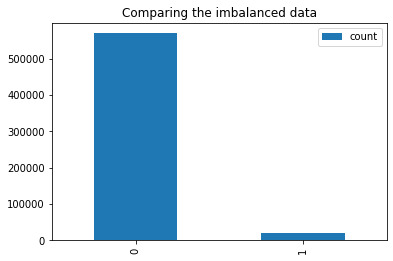

In [41]:
# In order to create plots, it is necessary to convert the dataframe from pyspark to pandas, and then plot it.
df_tr.groupby('isFraud').count().toPandas().plot(kind='bar', title='Comparing the imbalanced data')

In [42]:
df_tr.show(5, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+----+----+----+----+-----------------+-------------------+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

### Hypothesis

According to market practices, there are some well-known practices within e-commerce fraud:

- Customer abuse: customers abusing merchandise returning policies in order to obtain advantages. Among the abuses, one common practices is returning single used merchandise and falsely declaring not delivered merchandise.

- Money Mules: fraudsters influence legitimate accounts to purchase merchandise, which is hard to track. One particular situation is known as 'sweetheart mule', in which the fraudster and legit buyer are romantically involved during a long period of time (e.g. 2 years) before the fraud event happens.

- High value items: common merchandise target by fraudsters are high value itens, like eletronics, jewely and gold, which are easier to transport in person.

- Identity theft: fraudster use stollen personal information to acquire merchandise and even acquire loans. Possible signals of this practice is irregular consumer behavior, divergence between delivery location and IP address physical location registered during and purchase.

The dataset provides a limited selection of variables, therefore not all hypothesis can be explored. For now, two strategies will be used:

1. Focus on the user: identify each user buyer habits and indicates if there is irregular transactions events.
2. Focus on the merchandise: identify with type of merchandise is more target by fraudsters.  

In [43]:
# First strategy: focus on the user.
# Idea: frauds are usually commited more than once by the same buyer.
# Method: creating a index dividing number of fraud transaction by total number of transaction for every buyer.
# Expectations: the distribution of the custom index will not be concentrated in the left wing. 

df_id.show(5, 0)

+-------------+-----+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------+-----+------+-----+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------+----------+------------------+-----+---------+--------------+-----+-----+-----+-----+----------+-----------+
|TransactionID|id_01|id_02   |id_03|id_04|id_05|id_06|id_07|id_08|id_09|id_10|id_11|id_12   |id_13|id_14 |id_15|id_16   |id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29   |id_30     |id_31             |id_32|id_33    |id_34         |id_35|id_36|id_37|id_38|DeviceType|DeviceInfo |
+-------------+-----+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------+-----+------+-----+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------+----------+------------------+-----+---------+--------------+-----+-----+-----+-----+----------+-----------+
|2987066      |-5.0 |54927.0 |0.0  |0.0  |0.0  |-1.0 |null |null |0

In [44]:
df_tr.show(5, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+----+----+----+----+-----------------+-------------------+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

In [45]:
# Tryng to identify a unique column. Maybe 'id_02' in identity table?
df_h1 = df_id.groupBy('id_02').agg(fx.count('TransactionID').alias('qty_transaction'))
df_h1 = df_h1.orderBy(fx.col('qty_transaction').desc())

df_h1.show(5, 0)

+------+---------------+
|id_02 |qty_transaction|
+------+---------------+
|null  |3361           |
|1102.0|11             |
|696.0 |10             |
|1141.0|9              |
|1117.0|9              |
+------+---------------+
only showing top 5 rows



In [46]:
# Let's see in depth id_02 == 11.
df_tr.join(df_id, on='TransactionID', how='inner')\
     .filter(df_id['id_02'] == 1102)\
     .orderBy(fx.col('TransactionDT').asc()).show()

+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+----+----+----+----+----+-----+----+------------------+-------------------+-----+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+------+-----+---+----+----+-----+------+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--

In [47]:
# Alternative: what if the focus on the card information instead of the user.
# ex: in my wallet there is a credit card 1 for day-to-day purchaise (like clothes and market) and a credit card 2 for more expensive things (like buying a car).

# Create a column concatenating credit card information.
df_tr = df_tr.withColumn("card_concat", fx.concat(
        fx.col("card1"), fx.lit("_"),
        fx.col("card2").cast('int').cast('string'), fx.lit("_"),
        fx.col("card3").cast('int').cast('string'), fx.lit("_"),
        fx.col("card4"), fx.lit("_"),
        fx.col("card5").cast('int').cast('string'), fx.lit("_"),
        fx.col("card6")
    )
)
df_tr.show(2, 0)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+-----+----+---+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

In [48]:
# What is the average number of transactions and average amount value by card_concat?
df_tr.createOrReplaceTempView("transaction")
spark.sql('''
    SELECT  COUNT(card_concat) AS number_card,
            ROUND(AVG(qty), 1),
            ROUND(AVG(vl), 1)
    FROM (
        SELECT DISTINCT 
            card_concat,
            COUNT(TransactionID) AS qty,
            ROUND(AVG(TransactionAmt), 1) AS vl
        FROM transaction
        GROUP BY 1
    )
''').show()

+-----------+------------------+-----------------+
|number_card|round(avg(qty), 1)|round(avg(vl), 1)|
+-----------+------------------+-----------------+
|      13691|              43.1|            148.9|
+-----------+------------------+-----------------+



In [49]:
# What is the windows time for the dataset?
spark.sql('SELECT MAX(TransactionDT) / 60 / 60 / 24 FROM transaction').show()

+---------------------------------------+
|(((max(TransactionDT) / 60) / 60) / 24)|
+---------------------------------------+
|                     115.74063657407407|
+---------------------------------------+



In [50]:
# Let's see an example:
df_tr.filter(df_tr['card_concat'] == '17188_321_150_visa_226_debit').show()

+-------------+-------+-------------+--------------+---------+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+-----+-----+----+----+-----------------+-------------------+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+----------

In [51]:
'''
Conclusion:

The attempts to identify users by card information were unsucessful.

The table above displays that transactions made by a single card_concat may have different
P_emaildomain, merchants, addresses, etc. It seems farfetched to consider that each single
card_concat may be a single customer.

Since this task will require more complex solutions, it will be paused for now.
'''

'\nConclusion:\n\nThe attempts to identify users by card information were unsucessful.\n\nThe table above displays that transactions made by a single card_concat may have different\nP_emaildomain, merchants, addresses, etc. It seems farfetched to consider that each single\ncard_concat may be a single customer.\n\nSince this task will require more complex solutions, it will be paused for now.\n'

In [52]:
# Second strategy: focus on the merchandise.
# How many Product CD we have and what are their fraud rates?
spark.sql("SELECT ProductCD, CAST(COUNT(TransactionID) AS INT), SUM(isFraud), ROUND(MEDIAN(TransactionAmt), 1), ROUND(AVG(isFraud), 3) FROM transaction GROUP BY ProductCD").show()

+---------+---------------------------------+------------+--------------------------------+----------------------+
|ProductCD|CAST(count(TransactionID) AS INT)|sum(isFraud)|round(median(TransactionAmt), 1)|round(avg(isFraud), 3)|
+---------+---------------------------------+------------+--------------------------------+----------------------+
|        C|                            68519|      8008.0|                            31.2|                 0.117|
|        W|                           439670|      8969.0|                            78.5|                  0.02|
|        S|                            11628|       686.0|                            35.0|                 0.059|
|        R|                            37699|      1426.0|                           125.0|                 0.038|
|        H|                            33024|      1574.0|                            50.0|                 0.048|
+---------+---------------------------------+------------+----------------------

In [53]:
# Fraud events have different behaviours conditional to ProductCD?
spark.sql("""
    SELECT 
        ProductCD,
        isFraud,
        card6,
        CAST(COUNT(TransactionID) AS INT),
        ROUND(MEDIAN(TransactionAmt), 1)
    FROM transaction
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3
""").show(100, 0)

+---------+-------+---------------+---------------------------------+--------------------------------+
|ProductCD|isFraud|card6          |CAST(count(TransactionID) AS INT)|round(median(TransactionAmt), 1)|
+---------+-------+---------------+---------------------------------+--------------------------------+
|C        |0      |null           |175                              |29.3                            |
|C        |0      |charge card    |12                               |25.8                            |
|C        |0      |credit         |22888                            |33.7                            |
|C        |0      |debit          |37436                            |29.1                            |
|C        |1      |null           |18                               |46.9                            |
|C        |1      |credit         |4663                             |36.0                            |
|C        |1      |debit          |3327                             |33.1

In [54]:
'''
Conclusion:
- C: high fraud rate. Transactions made with credit card presents a higher probability of fraud than debit card's transactions.
- H: moderate fraud rate. Transactions with higher amount values have a highter probability of fraud.
- R: moderate fraud rate. There is a similar number of transactions made with debit cards and credit cards.
- S: similar to R.
- W: small fraud rate. Frauds tends to be more frequent in credit card transactions and in higher amount values.
'''

"\nConclusion:\n- C: high fraud rate. Transactions made with credit card presents a higher probability of fraud than debit card's transactions.\n- H: moderate fraud rate. Transactions with higher amount values have a highter probability of fraud.\n- R: moderate fraud rate. There is a similar number of transactions made with debit cards and credit cards.\n- S: similar to R.\n- W: small fraud rate. Frauds tends to be more frequent in credit card transactions and in higher amount values.\n"